In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("online_retail_dataset.csv") 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Discount,PaymentMethod,ShippingCost,Category,SalesChannel,ReturnStatus,ShipmentProvider,WarehouseLocation,OrderPriority
0,221958,SKU_1964,White Mug,38,2020-01-01 00:00,1.71,37039.0,Australia,0.470000,Bank Transfer,10.79,Apparel,In-store,Not Returned,UPS,London,Medium
1,771155,SKU_1241,White Mug,18,2020-01-01 01:00,41.25,19144.0,Spain,0.190000,paypall,9.51,Electronics,Online,Not Returned,UPS,Rome,Medium
2,231932,SKU_1501,Headphones,49,2020-01-01 02:00,29.11,50472.0,Germany,0.350000,Bank Transfer,23.03,Electronics,Online,Returned,UPS,Berlin,High
3,465838,SKU_1760,Desk Lamp,14,2020-01-01 03:00,76.68,96586.0,Netherlands,0.140000,paypall,11.08,Accessories,Online,Not Returned,Royal Mail,Rome,Low
4,359178,SKU_1386,USB Cable,-30,2020-01-01 04:00,-68.11,NaN,United Kingdom,1.501433,Bank Transfer,NaN,Electronics,In-store,Not Returned,FedEx,NaN,Medium


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49782 entries, 0 to 49781
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   InvoiceNo          49782 non-null  int64  
 1   StockCode          49782 non-null  object 
 2   Description        49782 non-null  object 
 3   Quantity           49782 non-null  int64  
 4   InvoiceDate        49782 non-null  object 
 5   UnitPrice          49782 non-null  float64
 6   CustomerID         44804 non-null  float64
 7   Country            49782 non-null  object 
 8   Discount           49782 non-null  float64
 9   PaymentMethod      49782 non-null  object 
 10  ShippingCost       47293 non-null  float64
 11  Category           49782 non-null  object 
 12  SalesChannel       49782 non-null  object 
 13  ReturnStatus       49782 non-null  object 
 14  ShipmentProvider   49782 non-null  object 
 15  WarehouseLocation  46297 non-null  object 
 16  OrderPriority      497

In [9]:
df = df.dropna(subset=["ShippingCost"])  
df.fillna({"CustomerID": df["CustomerID"].mode()[0], "WarehouseLocation": "Unknown"}, inplace=True)


In [11]:
features = ["Quantity", "Discount", "ShippingCost", "OrderPriority", "SalesChannel", "Country"]
target = "UnitPrice"

X = df[features]
y = df[target]

In [17]:
categorical_features = ["OrderPriority", "SalesChannel", "Country"]
numerical_features = ["Quantity", "Discount", "ShippingCost"]
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.pipeline import Pipeline
lin_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])
lin_pipeline.fit(X_train, y_train)
lin_pred = lin_pipeline.predict(X_test)

ridge_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", Ridge(alpha=1.0))
])
ridge_pipeline.fit(X_train, y_train)
ridge_pred = ridge_pipeline.predict(X_test)

In [23]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

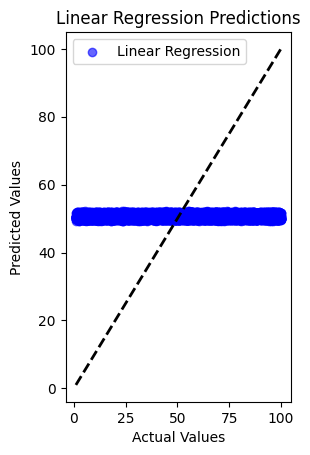

In [25]:
plt.subplot(1, 2, 1)
plt.scatter(y_test, lin_pred, color='blue', alpha=0.6, label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression Predictions")
plt.legend()

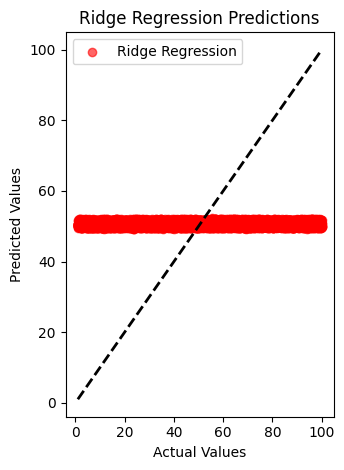

In [27]:
plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_pred, color='red', alpha=0.6, label='Ridge Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression Predictions")
plt.legend()

plt.tight_layout()
plt.show()


In [29]:
lin_coeff = lin_pipeline.named_steps["model"].coef_
ridge_coeff = ridge_pipeline.named_steps["model"].coef_

coefficients = pd.DataFrame({
    "Feature": numerical_features + list(preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)),
    "Linear Regression Coefficients": lin_coeff,
    "Ridge Regression Coefficients": ridge_coeff
})
print(coefficients)

                   Feature  Linear Regression Coefficients  \
0                 Quantity                       -0.124402   
1                 Discount                       -0.065304   
2             ShippingCost                        0.072578   
3       OrderPriority_High                       -0.075301   
4        OrderPriority_Low                        0.009836   
5     OrderPriority_Medium                        0.065465   
6    SalesChannel_In-store                        0.063519   
7      SalesChannel_Online                       -0.063519   
8        Country_Australia                       -0.134648   
9          Country_Belgium                        1.054949   
10          Country_France                       -0.694291   
11         Country_Germany                       -0.429406   
12           Country_Italy                        0.096554   
13     Country_Netherlands                       -0.696110   
14          Country_Norway                        0.216443   
15      

In [31]:
print("\nInterpretation:")
print("- Ridge regression coefficients are generally smaller, reducing overfitting.")
print("- If Ridge model has lower MSE, it suggests better generalization.")
print(f"MSE (Linear Regression): {mean_squared_error(y_test, lin_pred):.4f}")
print(f"MSE (Ridge Regression): {mean_squared_error(y_test, ridge_pred):.4f}")



Interpretation:
- Ridge regression coefficients are generally smaller, reducing overfitting.
- If Ridge model has lower MSE, it suggests better generalization.
MSE (Linear Regression): 822.9698
MSE (Ridge Regression): 822.9699
